## Part 1

In [ ]:
# Add all relevant imports to this line
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import itertools

from pprint import pprint
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

from sklearn.datasets import fetch_20newsgroups

### Question 1
Generate sparse TF-IDF representations: Following the steps in Project 1, transform the documents into TF-IDF vectors. Use `min_df = 3`, exclude the stopwords (no
need to do stemming or lemmatization), and remove the headers and footers. No need to
do any additional data cleaning.

**Report the dimensions of the TF-IDF matrix you obtain.**

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

newsgroup_classes = fetch_20newsgroups(subset='all',
                             categories=['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                                         'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'],
                             shuffle=True,
                             random_state=42,
                             remove=('headers', 'footers', 'quotes'))

# Initialize a TF-IDF Vectorizer
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(newsgroup_classes.data)

# Fit and transform the documents
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(X_counts)

# Separate Classes
labels = [0 if label < 4 else 1 for label in newsgroup_classes.target]

# Dimensions of the TF-IDF matrix
print(tfidf_matrix.shape)

(7882, 18469)


### Question 2
**Clustering:** Apply K-means clustering with k = 2 using the TF-IDF data. Note that
the KMeans class in sklearn has parameters named random state, max iter and n init.
Please use `random state=0`, `max iter ≥ 1000` and `n init ≥ 302`
. You can refer to sklearn Clustering text documents using k-means for a basic work flow.

- (a) Given the clustering result and ground truth labels, contingency table A is the matrix
whose entries A_ij is the number of data points that belong to the i'th class and the
j'th cluster.

**QUESTION 2:** Report the contingency table of your clustering result. You may use
the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?

In [ ]:
from sklearn.cluster import KMeans

# Applying K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
clusters = kmeans.fit_predict(tfidf_matrix)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Reworked code from plotmat.py from the 'Modules' tab of bruinlearn, altered to support visualization of larger contingency matrices
def plot_mat(mat, xticklabels=['Class 1', 'Class 2'], yticklabels=['Cluster 1', 'Cluster 2'], pic_fname=None, size=(12, 12), if_show_values=True,
             colorbar=True, grid='k', xlabel=None, ylabel=None, title=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=size)

    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)

    if colorbar:
        plt.colorbar(im, fraction=0.046)

    xtick_positions = np.arange(0.5, len(xticklabels))
    ytick_positions = np.arange(0.5, len(yticklabels))
    plt.xticks(xtick_positions, xticklabels if xticklabels is not None else ['Class 1', 'Class 2'])
    plt.yticks(ytick_positions, yticklabels if yticklabels is not None else ['Cluster 1', 'Cluster 2'])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="center", rotation_mode="anchor", fontsize=15)
    plt.setp(ax.get_yticklabels(), va="center", fontsize=15)

    plt.xlabel(xlabel if xlabel is not None else 'Ground Truth', fontsize=12)
    plt.ylabel(ylabel if ylabel is not None else 'Clustering Result', fontsize=12)
    plt.title(title if title is not None else 'Contingency Table', fontsize=14, fontweight='bold')

    ax.invert_yaxis()

    if if_show_values:
        for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
            ax.text(j + 0.5, i + 0.5, str(mat[i, j]),
                    horizontalalignment="center", verticalalignment="center", fontsize=25)

    plt.tight_layout()
    plt.show()

In [ ]:
cm = contingency_matrix(labels, clusters)
plot_mat(cm)

**QUESTION 3:** Report the 5 clustering measures explained in the introduction for Kmeans clusterin

In [ ]:
# Calculating Clustering Measures
def report_metrics(true_labels, cluster_labels):
  print("Homogeneity: %0.3f" % metrics.homogeneity_score(true_labels, cluster_labels))
  print("Completeness: %0.3f" % metrics.completeness_score(true_labels, cluster_labels))
  print("V-measure: %0.3f" % metrics.v_measure_score(true_labels, cluster_labels))
  print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(true_labels, cluster_labels))
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf_matrix, cluster_labels, metric='euclidean'))

report_metrics(labels, clusters)

### Question 4
First we want to find the effective dimension of the data through inspection of the top singular values of the TF-IDF matrix and see how many of them are significant in reconstructing the matrix with the truncated SVD representation. A guideline is to see what ratio of the variance of the original data is retained after the dimensionality
reduction.

**QUESTION 4:** Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

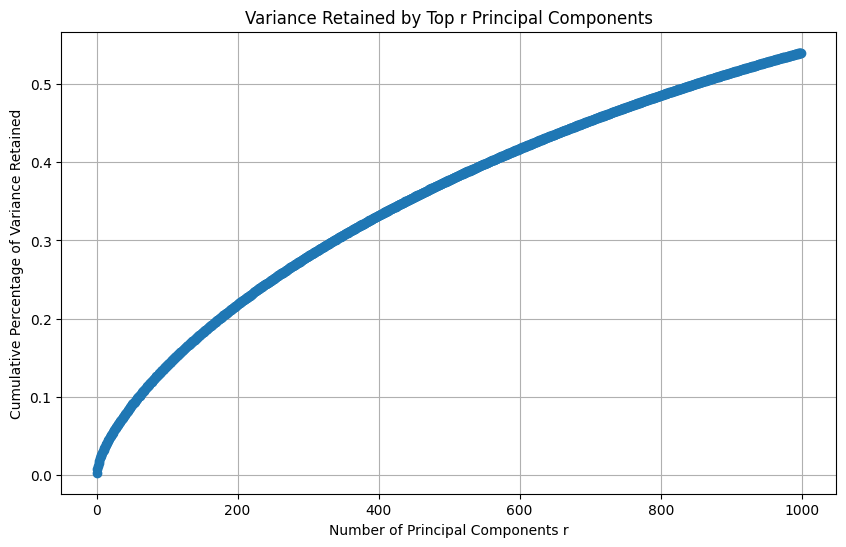

In [ ]:
# Assuming tfidf_matrix is the TF-IDF matrix obtained previously
svd = TruncatedSVD(n_components=1000)
svd.fit(tfidf_matrix)

# Calculate the percentage of variance explained by each of the selected components
variance_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the percentage of variance vs. the number of components
plt.figure(figsize=(10, 6))
plt.plot(variance_explained, marker='o')
plt.title('Variance Retained by Top r Principal Components')
plt.xlabel('Number of Principal Components r')
plt.ylabel('Cumulative Percentage of Variance Retained')
plt.grid(True)
plt.show()

### Question 5
Now, use the following two methods to reduce the dimension of the data. Sweep over
the dimension parameters for each method, and choose one that yields better results
in terms of clustering purity metrics.
- Truncated SVD / PCA
Note that you don't need to perform SVD multiple times: performing SVD with r = 1000 gives you
the data projected on all the top 1000 principle components, so for smaller r's, you just need to exclude
the least important features.
- NMF

**QUESTION 5:**
Let r be the dimension that we want to reduce the data to (i.e. n components).
Try `r = 1 - 10, 20, 50, 100, 300`, and plot the 5 measure scores v.s. r for both SVD
and NMF.
Report a good choice of r for SVD and NMF respectively.


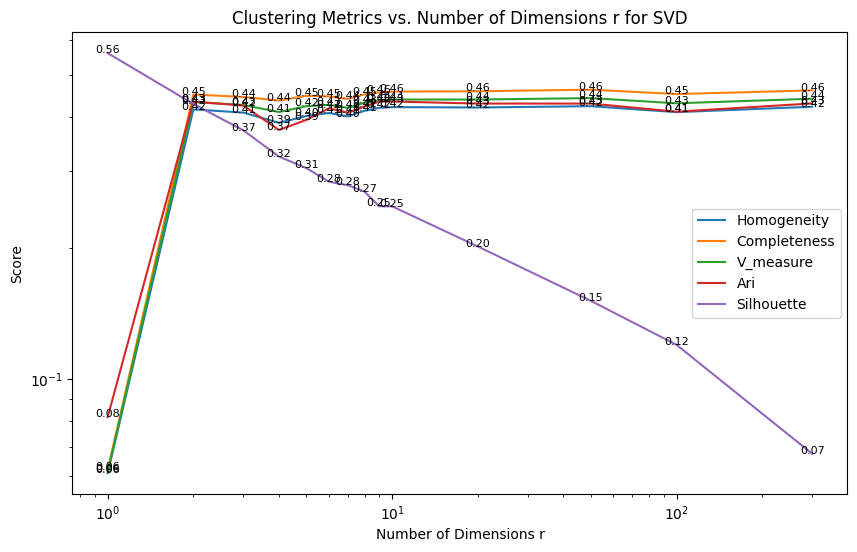

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

rs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
scores_svd = {'homogeneity': [], 'completeness': [], 'v_measure': [], 'ari': [], 'silhouette': []}

# Truncated SVD
for r in rs:
    svd = TruncatedSVD(n_components=r)
    X_reduced_svd = svd.fit_transform(tfidf_matrix)

    # K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    clusters = kmeans.fit_predict(X_reduced_svd)

    # Evaluate clustering
    scores_svd['homogeneity'].append(metrics.homogeneity_score(labels, clusters))
    scores_svd['completeness'].append(metrics.completeness_score(labels, clusters))
    scores_svd['v_measure'].append(metrics.v_measure_score(labels, clusters))
    scores_svd['ari'].append(metrics.adjusted_rand_score(labels, clusters))
    scores_svd['silhouette'].append(metrics.silhouette_score(X_reduced_svd, clusters, metric='euclidean'))

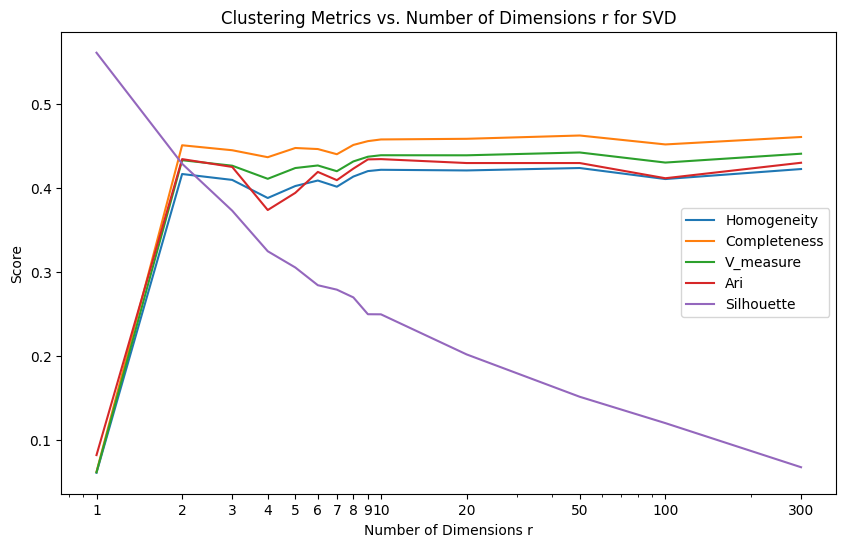

In [ ]:
import matplotlib.ticker as ticker

# Plotting for SVD with modifications
plt.figure(figsize=(10, 6))
for metric in scores_svd:
    plt.plot(rs, scores_svd[metric], label=metric.capitalize())

    # # Uncomment for score values over each data point:
    # for i, score in enumerate(scores_svd[metric]):
    #     plt.text(rs[i], score, f"{score:.2f}", fontsize=8, ha='center')

plt.xlabel('Number of Dimensions r')
plt.ylabel('Score')
plt.title('Clustering Metrics vs. Number of Dimensions r for SVD')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xticks(rs, labels=[str(r) for r in rs])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
plt.legend()
plt.show()

In [ ]:
# This cell takes around 10 minutes to run
rs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
scores_nmf = {'homogeneity': [], 'completeness': [], 'v_measure': [], 'ari': [], 'silhouette': []}

# Truncated SVD
for r in rs:
    nmf = NMF(n_components=r)
    X_reduced_nmf = nmf.fit_transform(tfidf_matrix)

    # K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    clusters = kmeans.fit_predict(X_reduced_nmf)

    # Evaluate clustering
    scores_nmf['homogeneity'].append(metrics.homogeneity_score(labels, clusters))
    scores_nmf['completeness'].append(metrics.completeness_score(labels, clusters))
    scores_nmf['v_measure'].append(metrics.v_measure_score(labels, clusters))
    scores_nmf['ari'].append(metrics.adjusted_rand_score(labels, clusters))
    scores_nmf['silhouette'].append(metrics.silhouette_score(X_reduced_nmf, clusters, metric='euclidean'))


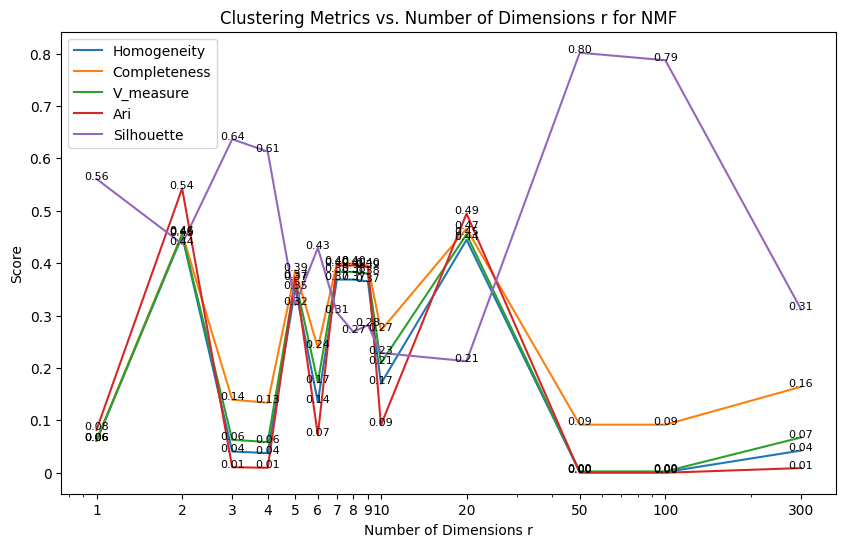

In [ ]:
# Plotting for SVD with modifications
plt.figure(figsize=(10, 6))
for metric in scores_nmf:
    plt.plot(rs, scores_nmf[metric], label=metric.capitalize())

    # # Uncomment for score values over each data point:
    for i, score in enumerate(scores_nmf[metric]):
        plt.text(rs[i], score, f"{score:.2f}", fontsize=8, ha='center')

plt.xlabel('Number of Dimensions r')
plt.ylabel('Score')
plt.title('Clustering Metrics vs. Number of Dimensions r for NMF')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xticks(rs, labels=[str(r) for r in rs])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
plt.legend()
plt.show()

### Question 8
Visualize the clusters
We can visualize the clustering results by projecting the dimension-reduced data points
onto a 2-D plane by once again using SVD, and coloring the points according to the:
- Ground truth class label;
- Clustering label

respectively.

**QUESTION 8:** Visualize the clustering results for:
- SVD with your optimal choice of r for K-Means clustering;
- NMF with your choice of r for K-Means clustering.

In [ ]:
def visualize_cluster_svd(tfidf_matrix, optimal_r):
  svd = TruncatedSVD(n_components=optimal_r)
  X_reduced_svd = svd.fit_transform(tfidf_matrix)

  # Apply K-means
  kmeans = KMeans(n_clusters=2, random_state=0)
  clusters_svd = kmeans.fit_predict(X_reduced_svd)

  svd_2d = TruncatedSVD(n_components=2)
  X_2d_svd = svd_2d.fit_transform(tfidf_matrix)

  # Plotting
  plt.figure(figsize=(12, 6))

  # Ground truth
  plt.subplot(1, 2, 1)
  plt.scatter(X_2d_svd[:, 0], X_2d_svd[:, 1], c=labels, cmap='viridis', alpha=0.5)
  plt.title('Ground Truth Labels with SVD')

  # Clustering result
  plt.subplot(1, 2, 2)
  plt.scatter(X_2d_svd[:, 0], X_2d_svd[:, 1], c=clusters_svd, cmap='viridis', alpha=0.5)
  plt.title('K-Means Clustering Labels with SVD')

  plt.show()

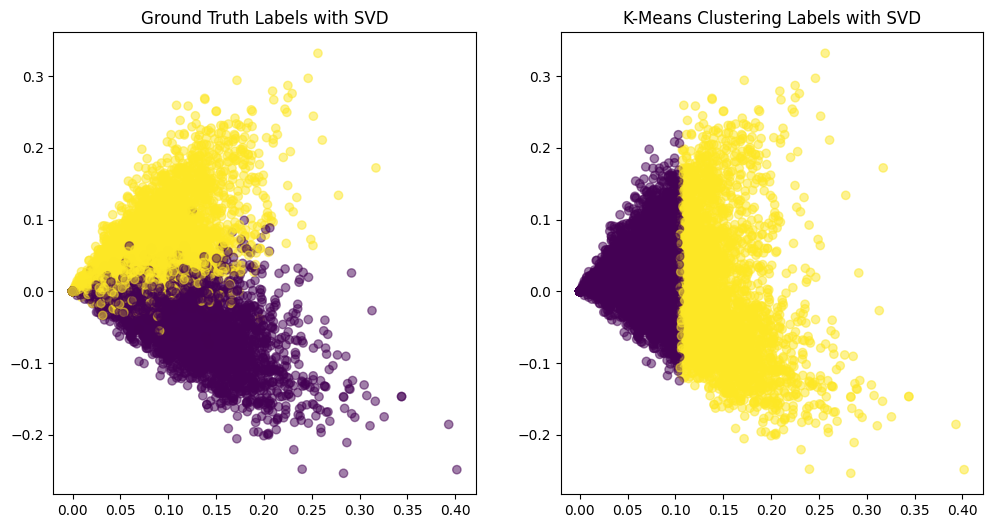

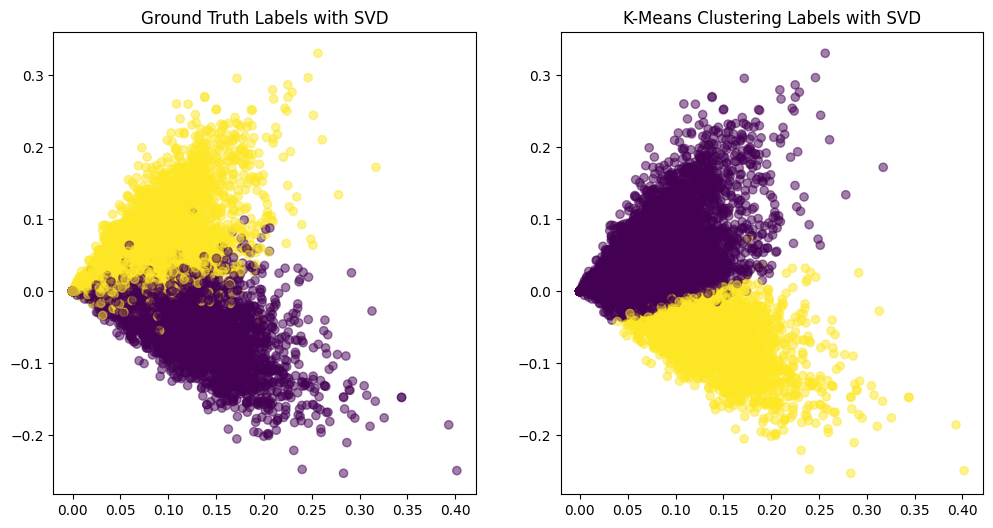

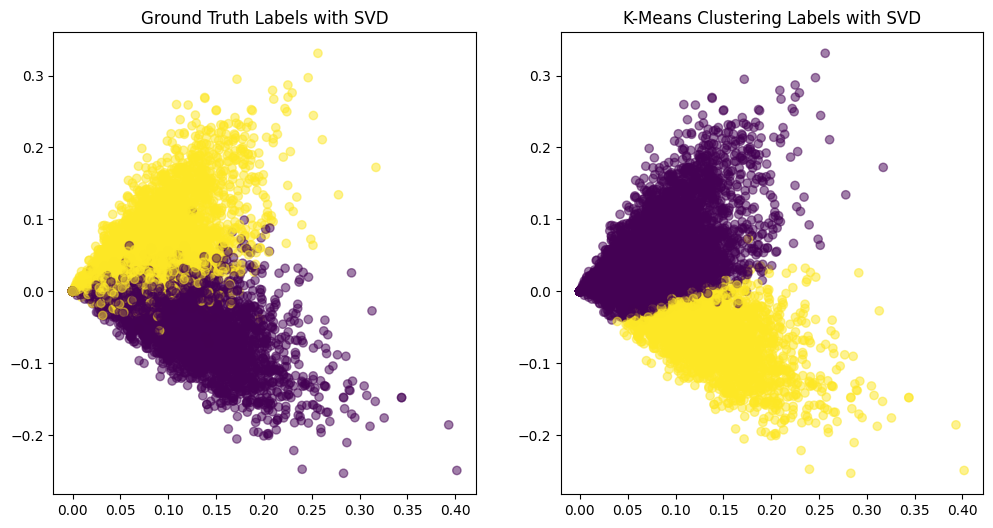

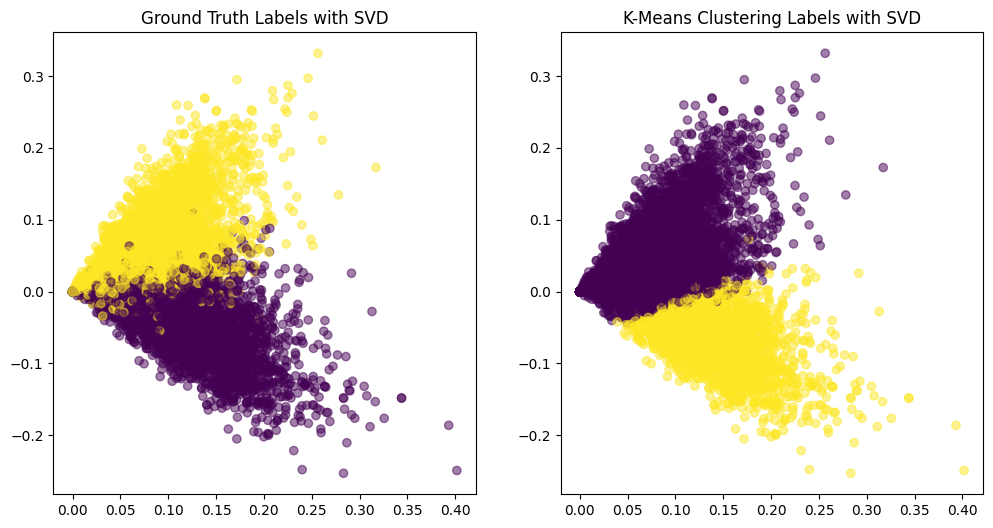

In [ ]:
visualize_cluster_svd(tfidf_matrix, 1)
visualize_cluster_svd(tfidf_matrix, 20)
visualize_cluster_svd(tfidf_matrix, 50)
visualize_cluster_svd(tfidf_matrix, 300)

In [ ]:
def visualize_cluster_nmf(tfidf_matrix, optimal_r = 100):
  nmf = NMF(n_components=optimal_r)
  X_reduced_nmf = nmf.fit_transform(tfidf_matrix)

  # Apply K-means
  kmeans_nmf = KMeans(n_clusters=2, random_state=0)
  clusters_nmf = kmeans_nmf.fit_predict(X_reduced_nmf)

  # For visualization, project the NMF-reduced data to 2-D using SVD (since NMF can't reduce to 2 directly)
  svd_2d_for_nmf = TruncatedSVD(n_components=2)
  X_2d_nmf = svd_2d_for_nmf.fit_transform(X_reduced_nmf)

  # Plotting
  plt.figure(figsize=(12, 6))

  # Ground truth
  plt.subplot(1, 2, 1)
  plt.scatter(X_2d_nmf[:, 0], X_2d_nmf[:, 1], c=labels, cmap='viridis', alpha=0.5)
  plt.title('Ground Truth Labels with NMF')

  # Clustering result
  plt.subplot(1, 2, 2)
  plt.scatter(X_2d_nmf[:, 0], X_2d_nmf[:, 1], c=clusters_nmf, cmap='viridis', alpha=0.5)
  plt.title('K-Means Clustering Labels with NMF')

  plt.show()

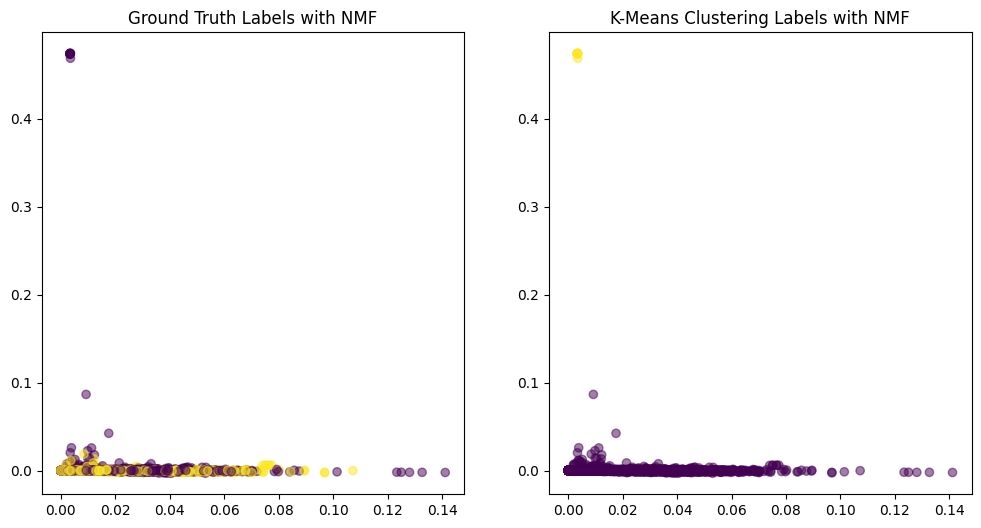

In [ ]:
# visualize_cluster_nmf(tfidf_matrix, 2)
# visualize_cluster_nmf(tfidf_matrix, 20)
# visualize_cluster_nmf(tfidf_matrix, 50)
visualize_cluster_nmf(tfidf_matrix, 100)
# visualize_cluster_nmf(tfidf_matrix, 300) # This takes around 8 minutes

### Question 10

Load documents with the same configuration as in Question 1, but for
ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF
and SVD (specify settings you choose and why), and perform K-Means clustering with k=20 .
Visualize the contingency matrix and report the five clustering metrics (DO BOTH
NMF AND SVD).

There is a mismatch between cluster labels and class labels. For example, the cluster #3 may
correspond to the class #8. As a result, the high-value entries of the 20 × 20 contingency
matrix can be scattered around, making it messy to inspect, even if the clustering result is not
bad.

One can use scipy.optimize linear_sum_assignment to identify the best-matching
cluster-class pairs, and permute the columns of the contingency matrix accordingly.

In [ ]:
# Load dataset
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Construct TF-IDF Matrix
tfidf_vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf_matrix_all = tfidf_vectorizer.fit_transform(newsgroups_all.data)

# Dimensionality Reduction (takes around 2 minutes)
X_reduced_svd = TruncatedSVD(n_components=100).fit_transform(tfidf_matrix_all)
X_reduced_nmf = NMF(n_components=100).fit_transform(tfidf_matrix_all)

# K-Means Clustering with k=20
kmeans_cluster = KMeans(n_clusters=20, random_state=0, n_init=30, max_iter=1000)
clusters_svd = kmeans_cluster.fit_predict(X_reduced_svd)
clusters_nmf = kmeans_cluster.fit_predict(X_reduced_nmf)

In [ ]:
# Report Metrics for SVD/NMF
from sklearn import metrics
def report_metrics(true_labels, cluster_labels):
    print("Homogeneity:", metrics.homogeneity_score(true_labels, cluster_labels))
    print("Completeness:", metrics.completeness_score(true_labels, cluster_labels))
    print("V-measure:", metrics.v_measure_score(true_labels, cluster_labels))
    print("Adjusted Rand Index:", metrics.adjusted_rand_score(true_labels, cluster_labels))
    print("Silhouette Coefficient:", metrics.silhouette_score(tfidf_matrix_all, cluster_labels))

print("Metrics for SVD:")
report_metrics(newsgroups_all.target, clusters_svd)

print("\nMetrics for NMF:")
report_metrics(newsgroups_all.target, clusters_nmf)

Metrics for SVD:
Homogeneity: 0.2773792882151879
Completeness: 0.37282617685283154
V-measure: 0.3180971711845264
Adjusted Rand Index: 0.05992137354414444
Silhouette Coefficient: 0.0069727401561086215

Metrics for NMF:
Homogeneity: 0.09248923986722311
Completeness: 0.1739703048029724
V-measure: 0.12077166363555526
Adjusted Rand Index: 0.006838404461430072
Silhouette Coefficient: 0.008020431239131317


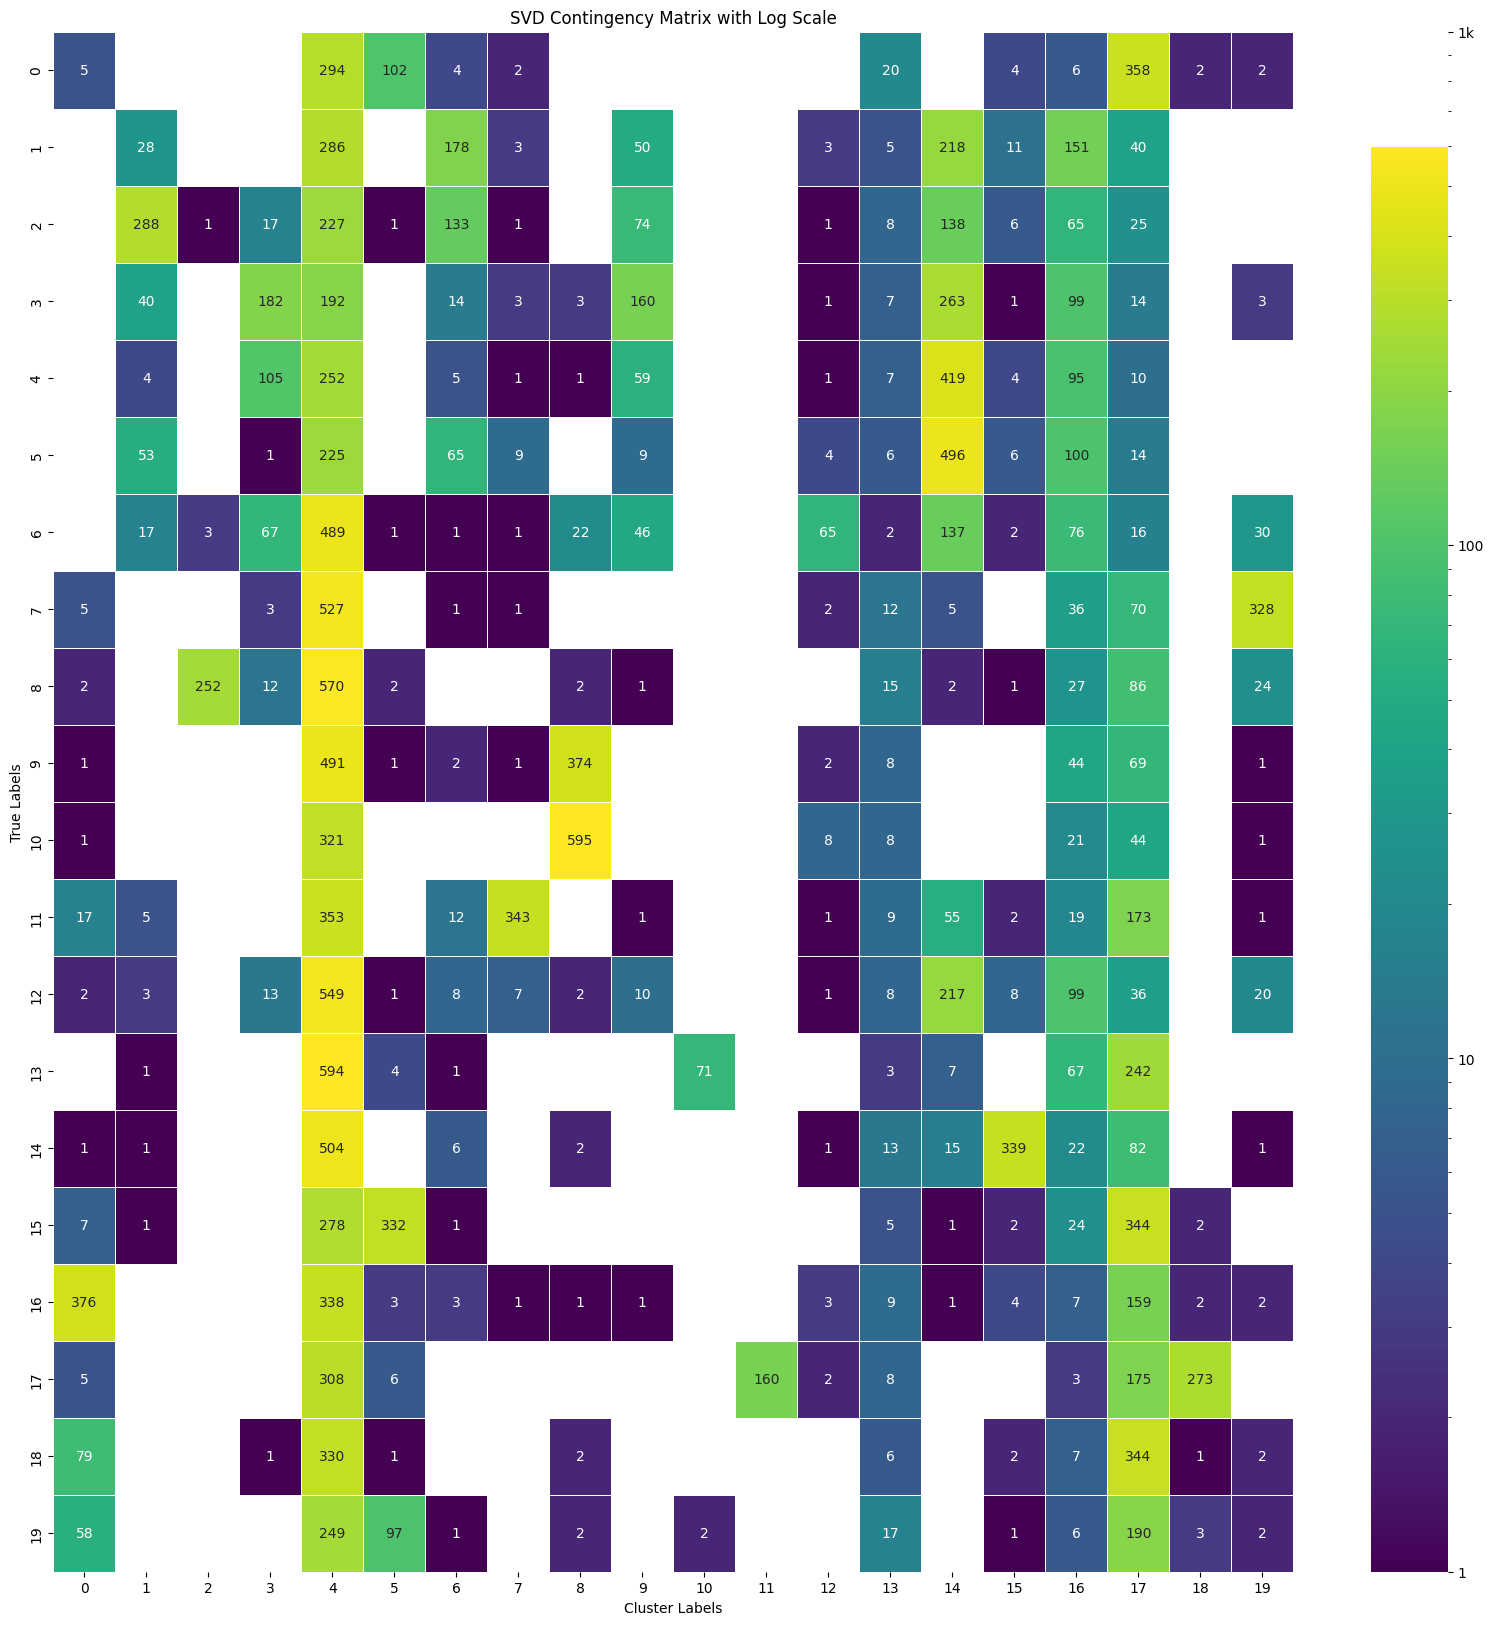

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

# Assuming `true_labels` contains the true labels and `best_clusters` contains your HDBSCAN cluster labels
cm = confusion_matrix(newsgroups_all.target, clusters_svd)

# Use a logarithmic color scale for better visibility of small numbers
# Set up the matplotlib figure and axis
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="viridis", norm=LogNorm())

ax.set_title('SVD Contingency Matrix with Log Scale')
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('True Labels')

# Adjust the color bar
cbar = ax.collections[0].colorbar
cbar.set_ticks([1, 10, 100, 1000])
cbar.set_ticklabels(['1', '10', '100', '1k'])

plt.show()

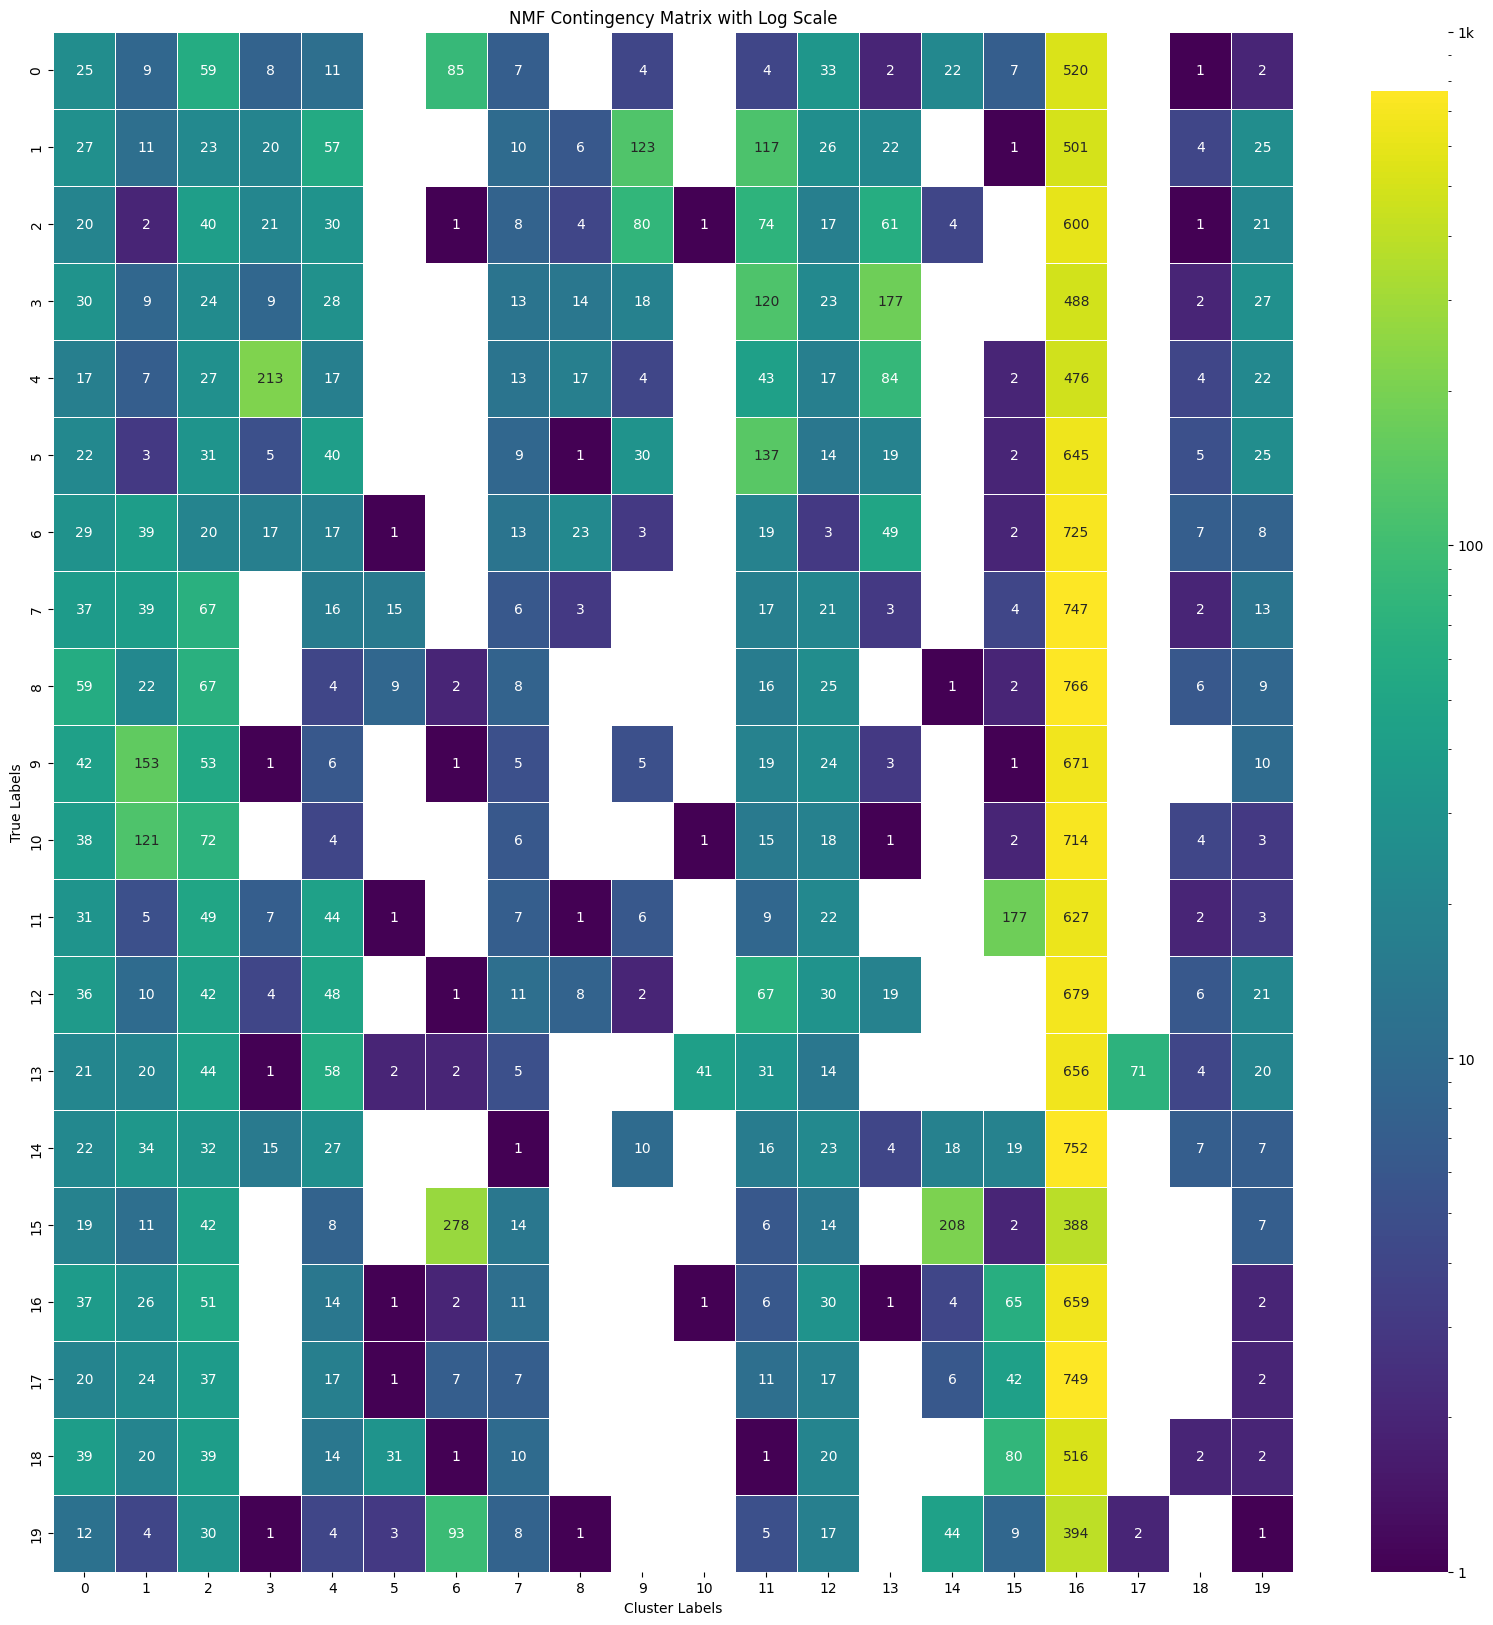

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

# Assuming `true_labels` contains the true labels and `best_clusters` contains your HDBSCAN cluster labels
cm = confusion_matrix(newsgroups_all.target, clusters_nmf)

# Use a logarithmic color scale for better visibility of small numbers
# Set up the matplotlib figure and axis
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="viridis", norm=LogNorm())

ax.set_title('NMF Contingency Matrix with Log Scale')
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('True Labels')

# Adjust the color bar
cbar = ax.collections[0].colorbar
cbar.set_ticks([1, 10, 100, 1000])
cbar.set_ticklabels(['1', '10', '100', '1k'])

plt.show()

### Question 11

Reduce the dimension of your dataset with UMAP. Consider the following
settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric
fails, please look at the FAQ at the end of this spec.

Report the permuted contingency matrix and the five clustering evaluation metrics
for the different combinations (6 combinations).

In [ ]:
# Should install pynndescent-0.5.11 and umap-learn-0.5.5, older versions will not work
!pip install --upgrade umap-learn
import umap

In [ ]:
# Suppress non-critical umap library warnings from output
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*n_jobs value.*')
warnings.filterwarnings('ignore', category=FutureWarning, message='.*The default value of `n_init`.*')

# Reimporting data here is not required but I've tweaked tfidf_vectorize params to work better with umap
# data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
# tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
# tfidf = tfidf_vectorizer.fit_transform(data.data)
# print("Data shape:", tfidf.shape)

In [ ]:
# Expect this cell to take a very long time to run

# Function to perform UMAP reduction, K-Means clustering, and evaluation
def evaluate_umap_clustering(data, n_components, metric):
    reducer = umap.UMAP(n_components=n_components, metric=metric, random_state=42)

    try:
        data_reduced = reducer.fit_transform(data)
    except ValueError as e:
        print(f"Error during UMAP reduction: {e}")
        return None

    clusters = KMeans(n_clusters=20, random_state=0).fit_predict(data_reduced)

    cm = confusion_matrix(newsgroups_all.target, clusters)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    cm_permuted = cm[rows[:, np.newaxis], cols]

    homogeneity = homogeneity_score(newsgroups_all.target, clusters)
    completeness = completeness_score(newsgroups_all.target, clusters)
    v_measure = v_measure_score(newsgroups_all.target, clusters)
    ari = adjusted_rand_score(newsgroups_all.target, clusters)
    silhouette = silhouette_score(data_reduced, clusters)

    return cm_permuted, homogeneity, completeness, v_measure, ari, silhouette

n_components_options = [5, 20, 200]
metrics = ["cosine", "euclidean"]

for n_components in n_components_options:
    for metric in metrics:
        try:
            cm_permuted, homogeneity, completeness, v_measure, ari, silhouette = evaluate_umap_clustering(tfidf_matrix_all, n_components, metric)
            print(f"Results for n_components={n_components}, metric={metric}:")
            print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-measure: {v_measure}, ARI: {ari}, Silhouette: {silhouette}")
        except Exception as e:
            print(f"Failed for n_components={n_components}, metric={metric} with error: {e}")


UMAP Reduction Successful
Results for n_components=5, metric=cosine:
Homogeneity: 0.45780407654707433, Completeness: 0.47570566454397306, V-measure: 0.466583224316939, ARI: 0.31894719851726877, Silhouette: 0.3641633987426758
UMAP Reduction Successful
Results for n_components=5, metric=euclidean:
Homogeneity: 0.008625221377907765, Completeness: 0.009557893776668271, V-measure: 0.009067637643986853, ARI: 0.0006061746129830106, Silhouette: 0.17847539484500885
UMAP Reduction Successful
Results for n_components=20, metric=cosine:
Homogeneity: 0.4507950604868615, Completeness: 0.4713194543397386, V-measure: 0.46082884177931166, ARI: 0.309741181018409, Silhouette: 0.3650643229484558
UMAP Reduction Successful
Results for n_components=20, metric=euclidean:
Homogeneity: 0.009689000933811564, Completeness: 0.010898578978627867, V-measure: 0.010258256905401596, ARI: 0.0007811873467745634, Silhouette: 0.12074040621519089
UMAP Reduction Successful
Results for n_components=200, metric=cosine:
Homogen

In [ ]:
plot_mat(cm_permuted)

### Question 14
Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single”
linkage criteria.

Report the five clustering evaluation metrics for each case.

In [ ]:
# Assuming tfidf_matrix_all is the TF-IDF matrix for the entire dataset

# Step 1: Dimensionality Reduction with UMAP
reducer = umap.UMAP(n_components=50, metric='cosine', random_state=42)
data_reduced = reducer.fit_transform(tfidf_matrix_all)

# Function to perform Agglomerative Clustering and evaluate metrics
def evaluate_agglomerative_clustering(data, linkage):
    clustering = AgglomerativeClustering(n_clusters=20, linkage=linkage)
    clusters = clustering.fit_predict(data)

    # Compute the metrics
    homogeneity = homogeneity_score(newsgroups_all.target, clusters)
    completeness = completeness_score(newsgroups_all.target, clusters)
    v_measure = v_measure_score(newsgroups_all.target, clusters)
    ari = adjusted_rand_score(newsgroups_all.target, clusters)
    silhouette = silhouette_score(data, clusters, metric='euclidean')  # Note: Silhouette might be computationally expensive

    return homogeneity, completeness, v_measure, ari, silhouette

# Evaluate for both "ward" and "single" linkage criteria
for linkage in ["ward", "single"]:
    metrics = evaluate_agglomerative_clustering(data_reduced, linkage)
    print(f"Metrics for {linkage} linkage:")
    print(f"Homogeneity: {metrics[0]}, Completeness: {metrics[1]}, V-measure: {metrics[2]}, ARI: {metrics[3]}, Silhouette: {metrics[4]}")


Metrics for ward linkage:
Homogeneity: 0.4307792310838353, Completeness: 0.46227934953742555, V-measure: 0.4459737514668628, ARI: 0.28620133162894884, Silhouette: 0.34760433435440063
Metrics for single linkage:
Homogeneity: 0.009609925217071026, Completeness: 0.12716210003525844, V-measure: 0.017869418392102453, ARI: 0.0001243338715371397, Silhouette: -0.37408116459846497


### Question 15

Apply HDBSCAN on UMAP-transformed 20-category data.

Use `min_cluster_size=100`.

Vary the min cluster size among 20, 100, 200 and report your findings in terms of the
five clustering evaluation metrics - you will plot the best contingency matrix in the
next question. Feel free to try modifying other parameters in HDBSCAN to get
better performance.

In [ ]:
!pip install hdbscan
import hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039279 sha256=6d51fadf21517537b5861e4548fe702f722333f3aa6376e4d31bc71543be9f9b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [ ]:
# UMAP Reduction
reducer = umap.UMAP(n_components=50, metric='cosine', random_state=42)
data_reduced = reducer.fit_transform(tfidf_matrix_all)

# Function to apply HDBSCAN and evaluate clustering performance
def evaluate_hdbscan(data, min_cluster_size):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
    clusters = clusterer.fit_predict(data)

    # Evaluation Metrics
    homogeneity = homogeneity_score(newsgroups_all.target, clusters)
    completeness = completeness_score(newsgroups_all.target, clusters)
    v_measure = v_measure_score(newsgroups_all.target, clusters)
    ari = adjusted_rand_score(newsgroups_all.target, clusters)
    silhouette = silhouette_score(data, clusters, metric='euclidean')

    return homogeneity, completeness, v_measure, ari, silhouette

In [ ]:
# Keep track of the best clustering model for question 16
best_score = 0
best_clusters = None
best_size = None

# Evaluate HDBSCAN with different min_cluster_sizes
for size in [20, 100, 200]:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size, gen_min_span_tree=True)
    clusters_temp = clusterer.fit_predict(data_reduced)

    # Compute the metrics
    homogeneity = homogeneity_score(newsgroups_all.target, clusters_temp)
    completeness = completeness_score(newsgroups_all.target, clusters_temp)
    v_measure = v_measure_score(newsgroups_all.target, clusters_temp)
    ari = adjusted_rand_score(newsgroups_all.target, clusters_temp)
    silhouette = silhouette_score(data_reduced, clusters_temp, metric='euclidean')

    print(f"Results for min_cluster_size={size}:")
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-measure: {v_measure}, ARI: {ari}, Silhouette: {silhouette}")

    # Update best model based on a chosen metric, e.g., V-measure
    if v_measure > best_score:
        best_score = v_measure
        best_clusters = clusters_temp
        best_size = size

print(f"Best model used min_cluster_size={best_size} with V-measure: {best_score}")


Results for min_cluster_size=20:
Homogeneity: 0.33405726746696973, Completeness: 0.37634711456015657, V-measure: 0.3539434493641508, ARI: 0.04881922256864343, Silhouette: -0.04922362044453621
Results for min_cluster_size=100:
Homogeneity: 0.0006602952494961827, Completeness: 0.014803402031630292, V-measure: 0.0012642016796070616, ARI: 2.9561046701935183e-05, Silhouette: 0.8050383925437927
Results for min_cluster_size=200:
Homogeneity: 0.0006602952494961827, Completeness: 0.014803402031630292, V-measure: 0.0012642016796070616, ARI: 2.9561046701935183e-05, Silhouette: 0.8050383925437927
Best model used min_cluster_size=20 with V-measure: 0.3539434493641508


### Question 16

Contingency matrix
Plot the contingency matrix for the best clustering model from Question 15.

How many clusters are given by the model? What does “-1” mean for the clustering labels?

Interpret the contingency matrix considering the answer to these questions.

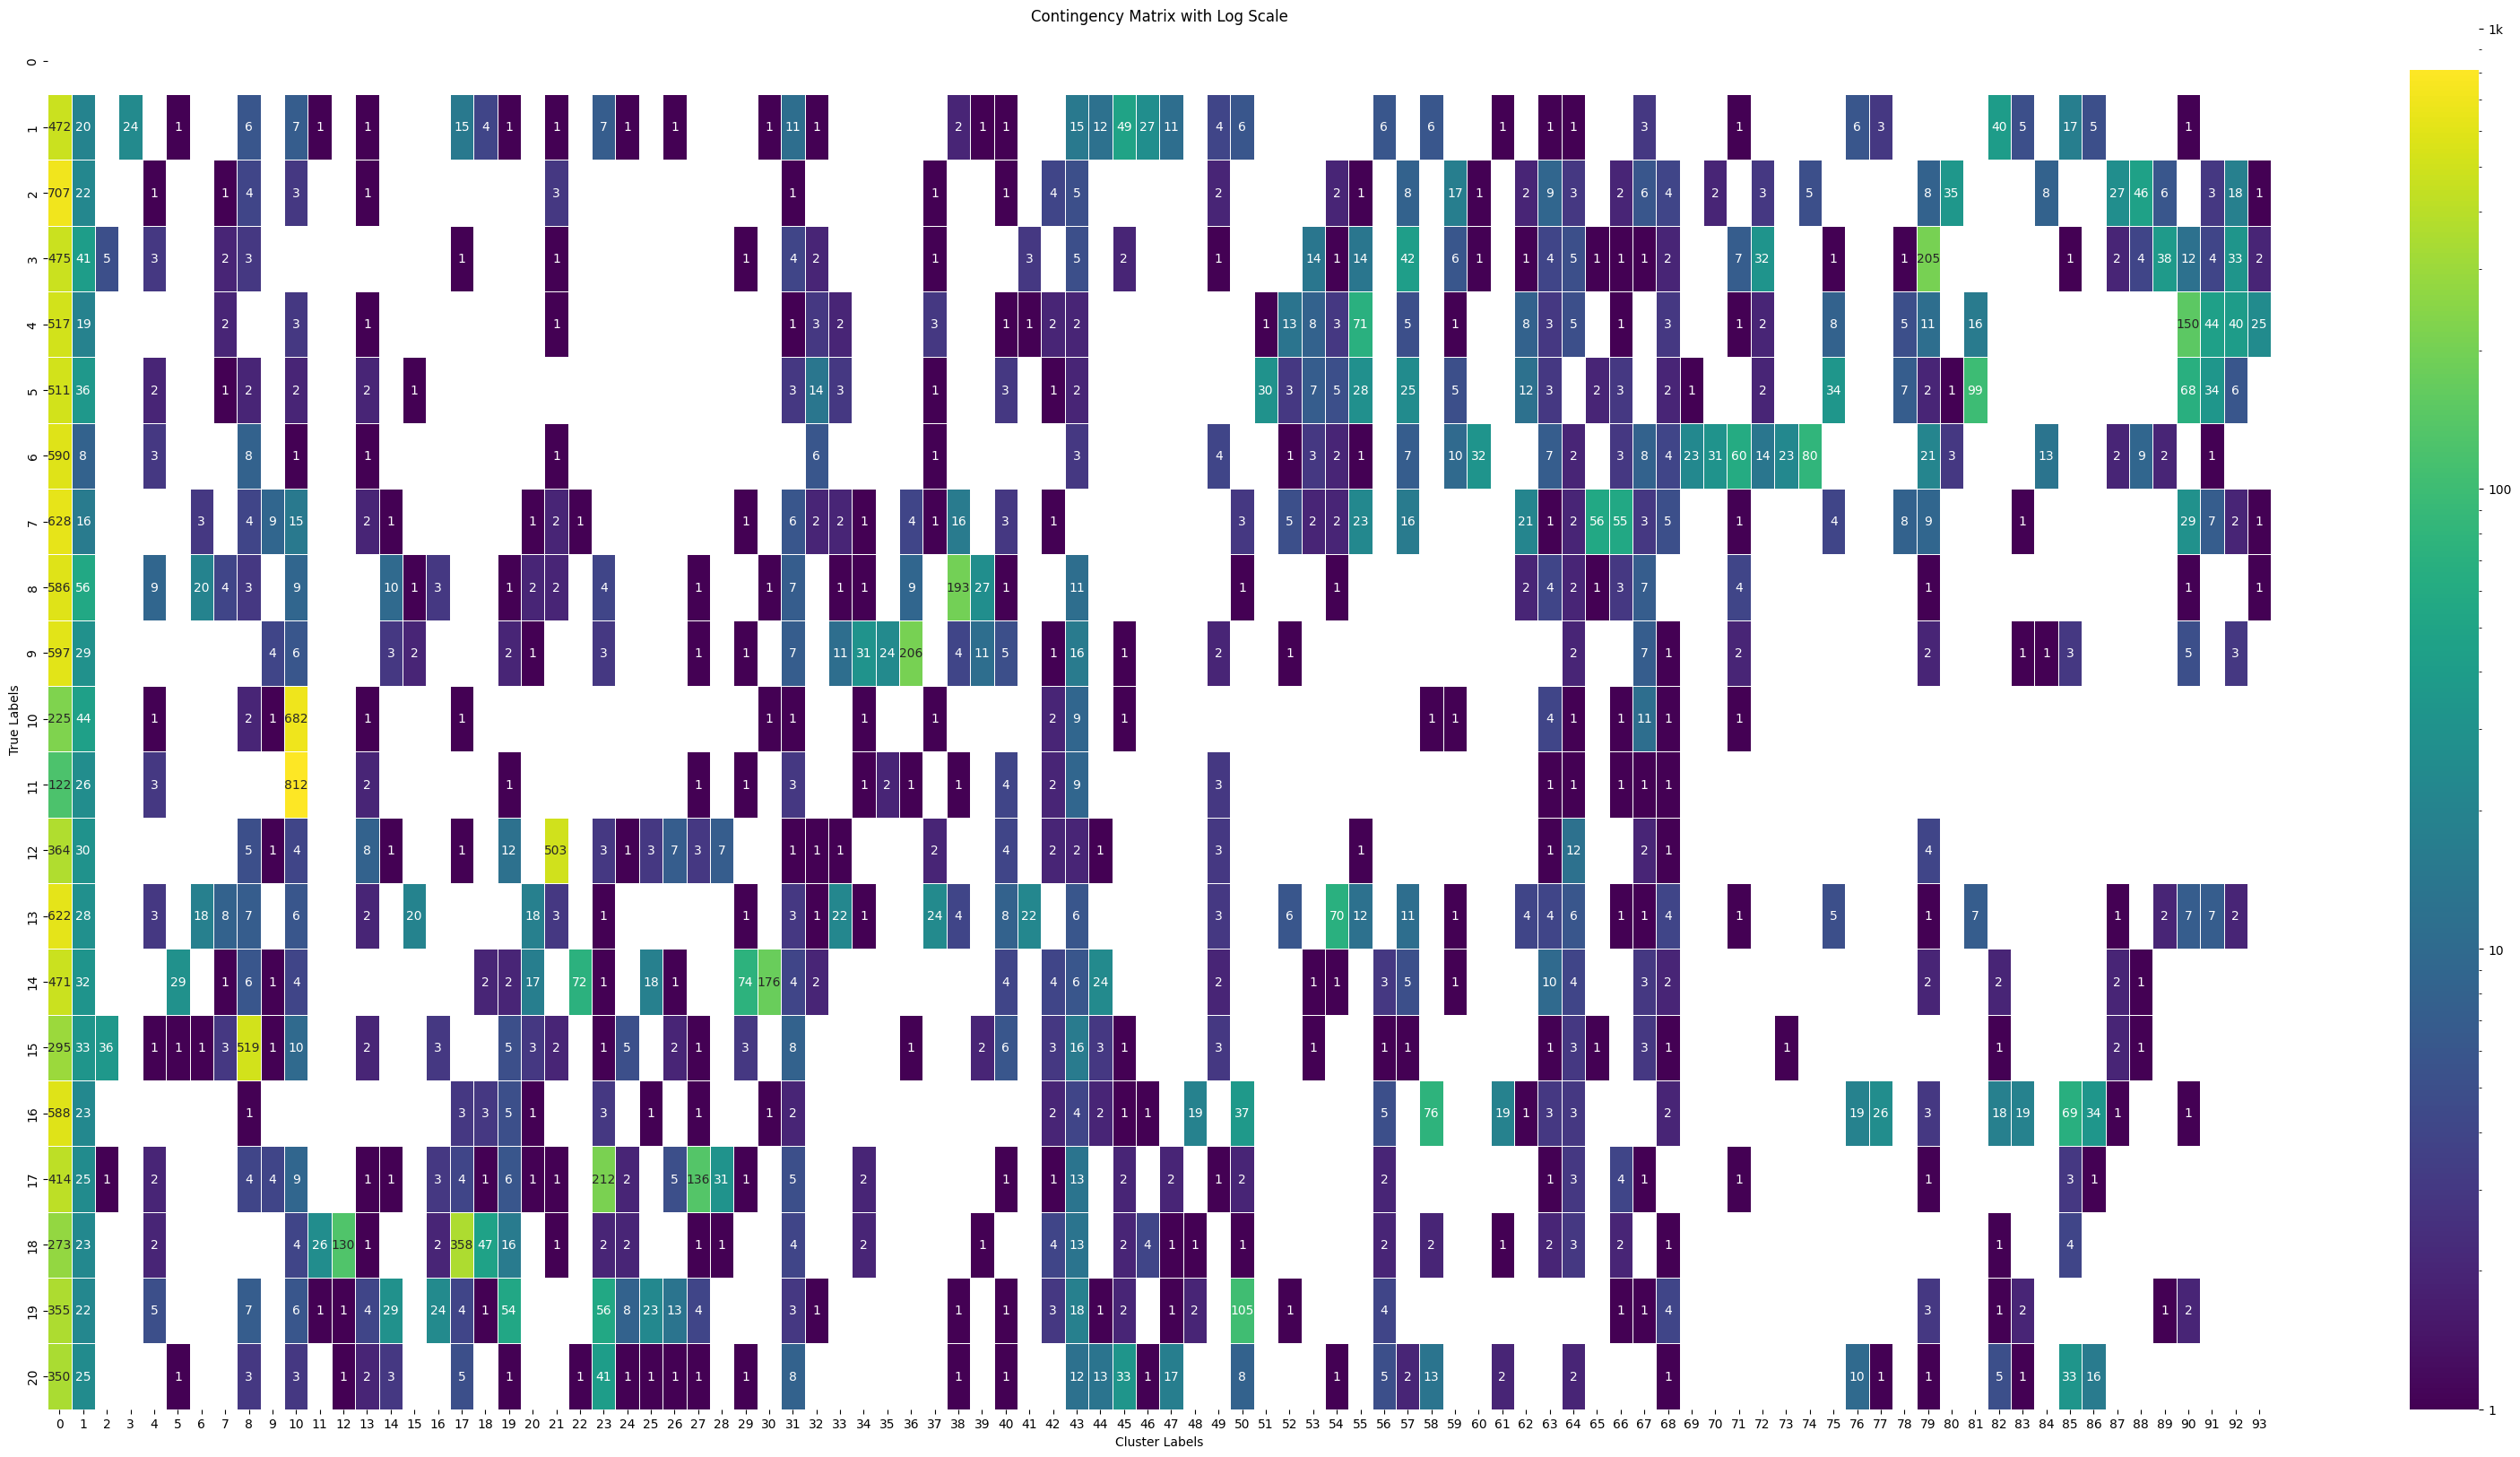

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

# Assuming `true_labels` contains the true labels and `best_clusters` contains your HDBSCAN cluster labels
cm = confusion_matrix(newsgroups_all.target, best_clusters)

# Exclude the noise label (-1) if present
if -1 in best_clusters:
    # Assuming noise label is the first column in cm
    cm = cm[:21, :]

# Use a logarithmic color scale for better visibility of small numbers
# Set up the matplotlib figure and axis
fig, ax = plt.subplots(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="viridis", norm=LogNorm())

ax.set_title('Contingency Matrix with Log Scale')
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('True Labels')

# Adjust the color bar
cbar = ax.collections[0].colorbar
cbar.set_ticks([1, 10, 100, 1000])
cbar.set_ticklabels(['1', '10', '100', '1k'])

plt.show()

In [ ]:
# Calculate number of clusters
print(len(set(best_clusters)) - (1 if -1 in best_clusters else 0))

93


### Question 17

Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? Follow the table below. If
UMAP takes too long to converge, consider running it once and saving the intermediate results in
a pickle file.

Hint: DBSCAN and HDBSCAN do not accept the number of clusters as an input parameter. So pay close attention to how
the different clustering metrics are being computed for these methods.

In [ ]:
# I do not think this question requires code, but I might put something here if comparison requires some algorithmic logic

### Question 18 (Extra Credit)

In [ ]:
# Ensemble Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import normalize

# Normalize the reduced data
data_normalized = normalize(data_reduced)

# Apply PCA as a pre-step to UMAP reduced data
pca = PCA(n_components=10)
data_pca = pca.fit_transform(data_normalized)

# Create multiple clustering models
kmeans_models = [KMeans(n_clusters=20, random_state=i) for i in range(5)]

# Fit models and store cluster assignments
cluster_assignments = [kmeans.fit_predict(data_pca) for kmeans in kmeans_models]

# Majority vote or average cluster assignments
# For simplicity, let's take the mode of the cluster assignments
from scipy.stats import mode

clusters_mode, _ = mode(np.array(cluster_assignments), axis=0)
best_clusters = clusters_mode.flatten()

In [ ]:
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Supervised Metrics
def evaluate_supervised(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    print(f"Adjusted Rand Index: {ari}")
    print(f"Normalized Mutual Information: {nmi}")

# Unsupervised Metrics
def evaluate_unsupervised(data, predicted_labels):
    silhouette = silhouette_score(data, predicted_labels)
    print(f"Silhouette Score: {silhouette}")

# Evaluate clusters
evaluate_supervised(newsgroups_all.target, best_clusters)
evaluate_unsupervised(data_reduced, best_clusters)

In [ ]:
# Evaluate the 'best_clusters' as before
# Assuming `true_labels` contains the true labels and `best_clusters` contains your HDBSCAN cluster labels
cm = confusion_matrix(newsgroups_all.target, best_clusters)

# Exclude the noise label (-1) if present
if -1 in best_clusters:
    # Assuming noise label is the first column in cm
    cm = cm[:, :]

# Use a logarithmic color scale for better visibility of small numbers
# Set up the matplotlib figure and axis
fig, ax = plt.subplots(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="viridis", norm=LogNorm())

ax.set_title('Contingency Matrix with Log Scale')
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('True Labels')

# Adjust the color bar
cbar = ax.collections[0].colorbar
cbar.set_ticks([1, 10, 100, 1000])
cbar.set_ticklabels(['1', '10', '100', '1k'])

plt.show()

## Part 2

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:17<00:00, 31.6MB/s]
100%|██████████| 58/58 [00:34<00:00,  1.68it/s]


### Problem 21

How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
# print(num_features)
# print(f_all[1][20:])  # the feature is dense

(3670, 4096) (3670,)


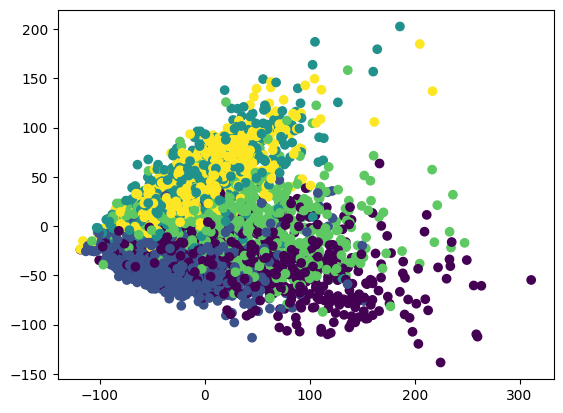

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

### Problem 23

In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.

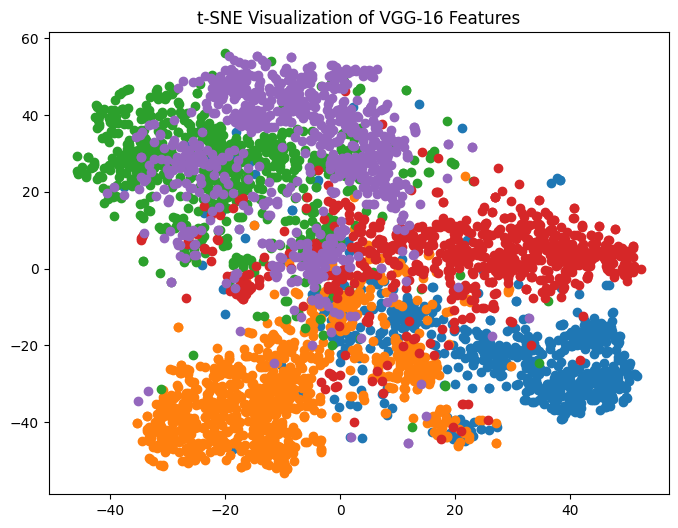

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
f_all_2d = tsne.fit_transform(f_all)

# Plot the mapped feature vectors with color-coded ground-truth labels
plt.figure(figsize=(8, 6))
for label in np.unique(y_all):
    indices = np.where(y_all == label)
    plt.scatter(f_all_2d[indices, 0], f_all_2d[indices, 1], label=label)
plt.title('t-SNE Visualization of VGG-16 Features')
# plt.legend(title='Ground Truth Labels')
plt.show()

MLP Classifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                optimizer.zero_grad()
                outputs = self.model(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()
                # raise NotImplementedError
        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        self.model.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        with torch.no_grad():
            outputs = self.model(X_test)
            _, predicted = torch.max(outputs, 1)
            accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())

        return accuracy
        # raise NotImplementedError

Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


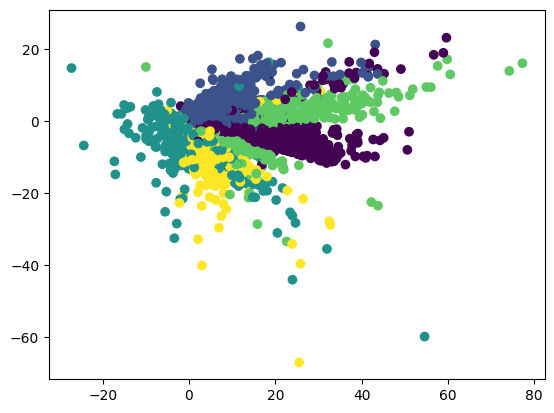

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

### Problem 24


Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
import hdbscan
import umap

def dimensionality_reduction(data, method='None', num_components=50):
    if method == 'None':
        return data
    elif method == 'SVD':
        svd = TruncatedSVD(n_components=num_components)
        return svd.fit_transform(data)
    elif method == 'UMAP':
        umap_reducer = umap.UMAP(n_components=num_components)
        return umap_reducer.fit_transform(data)
    elif method == 'Autoencoder':
        autoencoder = Autoencoder(n_components=num_components)
        autoencoder.fit(data)
        return autoencoder.transform(data)

def clustering(data, method='KMeans', **kwargs):
    if method == 'KMeans':
        kmeans = KMeans(n_clusters=kwargs['n_clusters'], random_state=42)
        return kmeans.fit_predict(data)
    elif method == 'Agglomerative':
        agg_clustering = AgglomerativeClustering(n_clusters=kwargs['n_clusters'])
        return agg_clustering.fit_predict(data)
    elif method == 'HDBSCAN':
        best_rand_score_hdbscan = -1
        best_min_cluster_size = None
        best_min_samples = None

        for min_cluster_size in kwargs['min_cluster_size_grid']:
            for min_samples in kwargs['min_samples_grid']:
                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
                labels_hdbscan = clusterer.fit_predict(data)
                rand_score_hdbscan = adjusted_rand_score(kwargs['labels_true'], labels_hdbscan)
                if rand_score_hdbscan > best_rand_score_hdbscan:
                    best_rand_score_hdbscan = rand_score_hdbscan
                    best_min_cluster_size = min_cluster_size
                    best_min_samples = min_samples

        print("- Best Rand Score (HDBSCAN):", best_rand_score_hdbscan)
        print("- Best min_cluster_size (HDBSCAN):", best_min_cluster_size)
        print("- Best min_samples (HDBSCAN):", best_min_samples)

def run_experiment(data, labels_true, dim_reduction_method='None', clustering_method='KMeans', dim_reduction_components=50, clustering_params={}):
    reduced_data = dimensionality_reduction(data, method=dim_reduction_method, num_components=dim_reduction_components)
    if clustering_method != 'HDBSCAN':
        labels_pred = clustering(reduced_data, method=clustering_method, **clustering_params)
        rand_score = adjusted_rand_score(labels_true, labels_pred)
        print(f"Experiment ({dim_reduction_method}, {clustering_method}) Rand Score: {rand_score}")
    else:
        print(f"Experiment ({dim_reduction_method}, {clustering_method})")
        clustering_params['labels_true'] = labels_true
        clustering(reduced_data, method=clustering_method, **clustering_params)

In [ ]:
def run_all_experiments(data, labels_true):
    dim_reduction_methods = ['None', 'SVD', 'UMAP', 'Autoencoder']
    clustering_methods = ['KMeans', 'Agglomerative', 'HDBSCAN']
    clustering_params = {
        'KMeans': {'n_clusters': 5},
        'Agglomerative': {'n_clusters': 5},
        'HDBSCAN': {'min_cluster_size_grid': [5, 10], 'min_samples_grid': [1, 2, 3]}
    }

    for cluster_method in clustering_methods:
        for dim_method in dim_reduction_methods:
            if cluster_method == 'HDBSCAN':
                run_experiment(data, labels_true, dim_reduction_method=dim_method, clustering_method=cluster_method, clustering_params=clustering_params[cluster_method])
            else:
                run_experiment(data, labels_true, dim_reduction_method=dim_method, clustering_method=cluster_method, clustering_params=clustering_params.get(cluster_method, {}))


run_all_experiments(f_all, y_all)

Experiment (None, KMeans) Rand Score: 0.18919803381799868
Experiment (SVD, KMeans) Rand Score: 0.19123637967513135
Experiment (UMAP, KMeans) Rand Score: 0.40811041157693556


100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


Experiment (Autoencoder, KMeans) Rand Score: 0.221027151179688
Experiment (None, Agglomerative) Rand Score: 0.24051166033092847
Experiment (SVD, Agglomerative) Rand Score: 0.2375609642467186
Experiment (UMAP, Agglomerative) Rand Score: 0.37604127761093387


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Experiment (Autoencoder, Agglomerative) Rand Score: 0.271126906049534
Experiment (None, HDBSCAN)
- Best Rand Score (HDBSCAN): 0.029935533978548482
- Best min_cluster_size (HDBSCAN): 5
- Best min_samples (HDBSCAN): 2
Experiment (SVD, HDBSCAN)
- Best Rand Score (HDBSCAN): 0.025581182239683267
- Best min_cluster_size (HDBSCAN): 5
- Best min_samples (HDBSCAN): 3
Experiment (UMAP, HDBSCAN)
- Best Rand Score (HDBSCAN): 0.05435887929051603
- Best min_cluster_size (HDBSCAN): 10
- Best min_samples (HDBSCAN): 3


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Experiment (Autoencoder, HDBSCAN)
- Best Rand Score (HDBSCAN): 0.024432358356232822
- Best min_cluster_size (HDBSCAN): 5
- Best min_samples (HDBSCAN): 2


### Problem 25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

mlp_original = MLP(num_features=f_all.shape[1]).cuda().train(X_train, y_train)
test_accuracy_original = mlp_original.eval(X_test, y_test)
print("Test Accuracy with original VGG features:", test_accuracy_original)

100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


Test Accuracy with original VGG features: 0.9005449591280654


In [ ]:
pca = PCA(n_components=100)  # Choose desired number of components
f_all_reduced = pca.fit_transform(f_all)
# f_all_reduced = f_pca
X_train_reduced, X_test_reduced = train_test_split(f_all_reduced, test_size=0.2, random_state=42)

# Train MLP classifier on reduced-dimensional features
mlp_reduced = MLP(num_features=f_all_reduced.shape[1]).cuda().train(X_train_reduced, y_train)
test_accuracy_reduced = mlp_reduced.eval(X_test_reduced, y_test)
print("Test Accuracy with reduced-dimensional features (PCA):", test_accuracy_reduced)

100%|██████████| 100/100 [00:07<00:00, 12.67it/s]

Test Accuracy with reduced-dimensional features (PCA): 0.9100817438692098


In [ ]:
pca = PCA(n_components=2)  # Choose desired number of components
f_all_reduced = pca.fit_transform(f_all)
X_train_reduced, X_test_reduced = train_test_split(f_all_reduced, test_size=0.2, random_state=42)

# Train MLP classifier on reduced-dimensional features
mlp_reduced = MLP(num_features=f_all_reduced.shape[1]).cuda().train(X_train_reduced, y_train)
test_accuracy_reduced = mlp_reduced.eval(X_test_reduced, y_test)
print("Test Accuracy with reduced-dimensional features (PCA):", test_accuracy_reduced)

100%|██████████| 100/100 [00:10<00:00,  9.94it/s]

Test Accuracy with reduced-dimensional features (PCA): 0.5299727520435967


## Part 3

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6r66pxie
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6r66pxie
  Resolved https://github.com/openai/CLIP.git 

In [ ]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [ ]:
!unzip -q images.zip

In [ ]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

### Question 26

Try to construct various text queries regarding types of Pokemon (such as ”type: Bug”, ”electric type Pok ́emon” or ”Pok ́emon with fire abilities”) to find the relevant images from the dataset. Once you have found the most suitable template for queries, please find the top five most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot the five most relevant Pokemon horizontally in one figure with following specifications:
- the title of the figure should be the query you used;
- the title of each Pokemon should be the name of the Pokemon and its first and second type.

In [ ]:
pokedex = construct_pokedex()
model, preprocess, device = load_clip_model()
print(device)

# Get image embeddings
image_paths = pokedex['image_path'].tolist()
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)

cuda


100%|██████████| 753/753 [00:15<00:00, 49.06it/s]


In [ ]:
def plot_top_pokemon(pokedex, image_embeddings, type_query):
    query = f"type: {type_query}"
    # query = f"{type_query} type Pokemon"
    # query = f"Pokemon with {type_query} abilities"
    text_embeddings = clip_inference_text(model, preprocess, [query], device)
    # print('image', image_embeddings.shape)
    # print('text', text_embeddings.shape)
    similarity = compute_similarity_image_to_text(image_embeddings, text_embeddings)
    # print(similarity[:10])
    # print(similarity.squeeze()[:10])
    # print(np.argsort()similarity.squeeze()[:10])
    relevant_pokemon_indices = np.argsort(-similarity.squeeze())[:5]
    relevant_pokemon = pokedex.iloc[relevant_pokemon_indices]

    plt.figure(figsize=(15, 5))
    plt.suptitle(query, fontsize=16)

    for i, (_, pokemon) in enumerate(relevant_pokemon.iterrows()):
        img_path = pokemon['image_path']
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{pokemon['Name']} ({pokemon['Type1']}, {pokemon['Type2']})")
        plt.axis('off')

    plt.show()

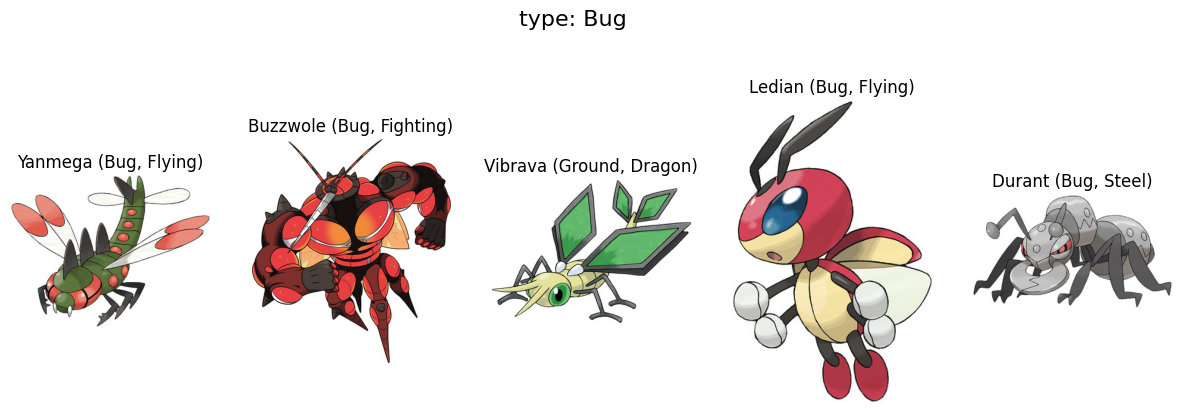

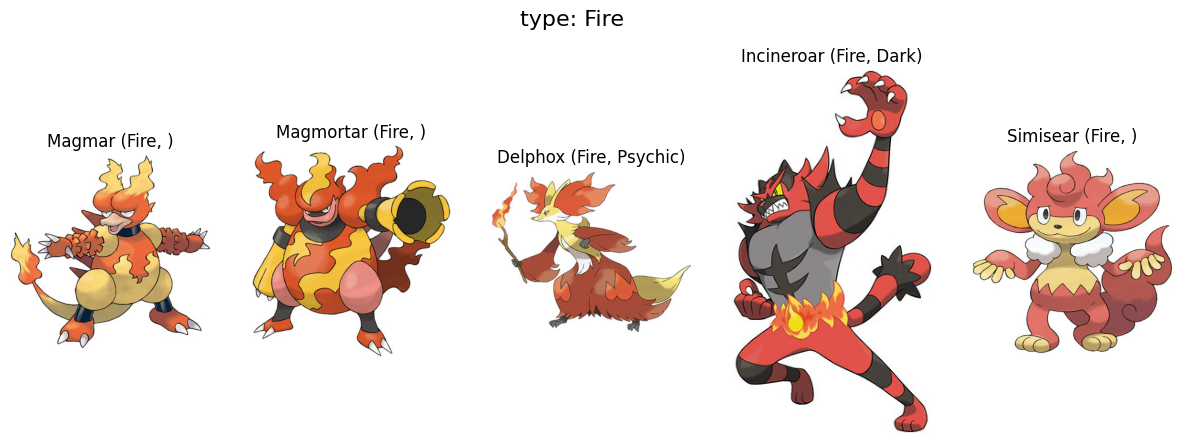

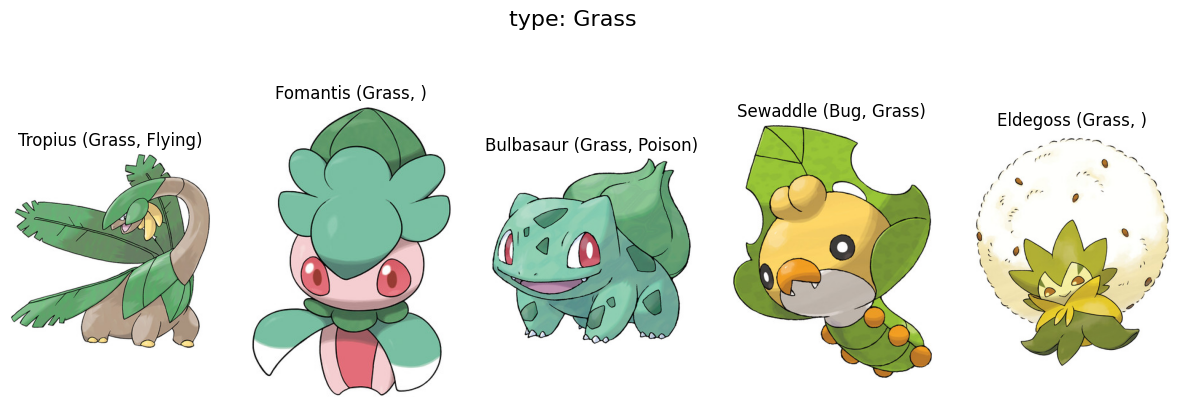

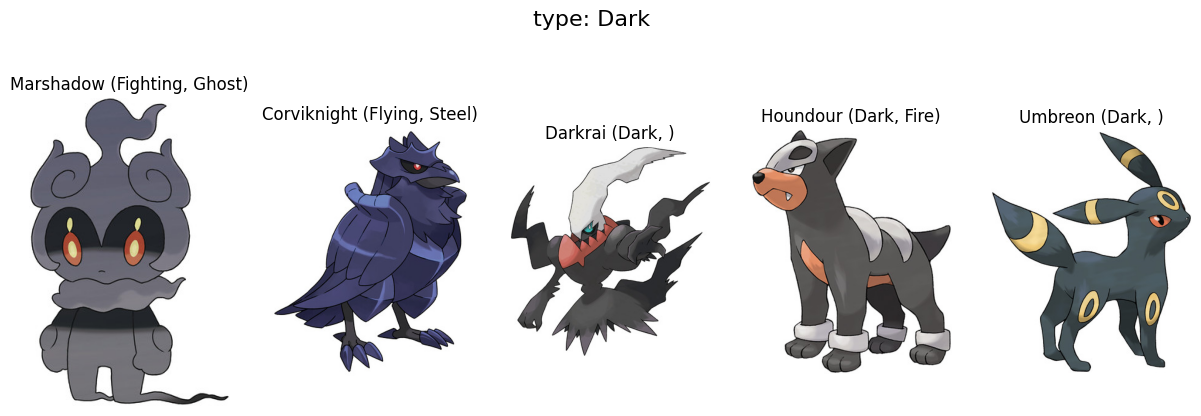

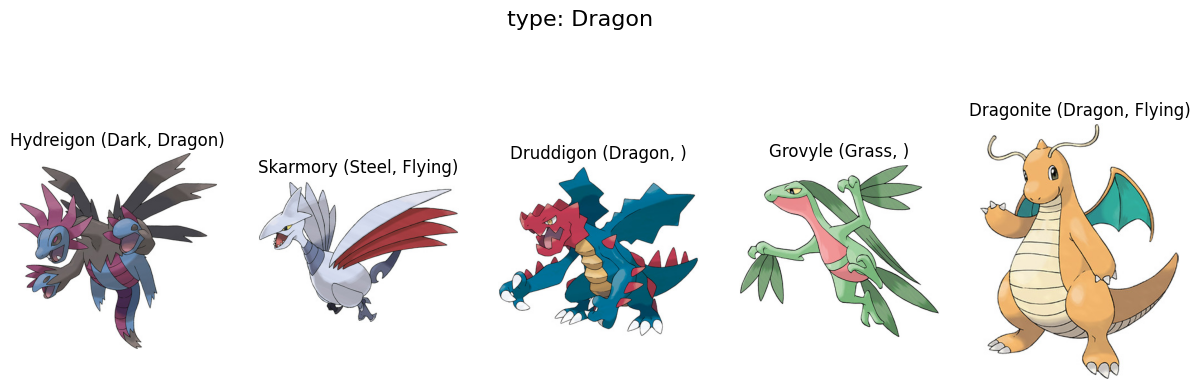

In [ ]:
# Plot top 5 relevant Pokemon for each type query
plot_top_pokemon(pokedex, image_embeddings, "Bug")
plot_top_pokemon(pokedex, image_embeddings, "Fire")
plot_top_pokemon(pokedex, image_embeddings, "Grass")
plot_top_pokemon(pokedex, image_embeddings, "Dark")
plot_top_pokemon(pokedex, image_embeddings, "Dragon")

### Question 27

Randomly select 10 Pokemon images from the dataset and use CLIP to find the most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon, please plot it and indicate:
- its name and first and second type;
- the five most relevant types predicted by CLIP and their predicted probabilities.

100%|██████████| 10/10 [00:00<00:00, 47.19it/s]


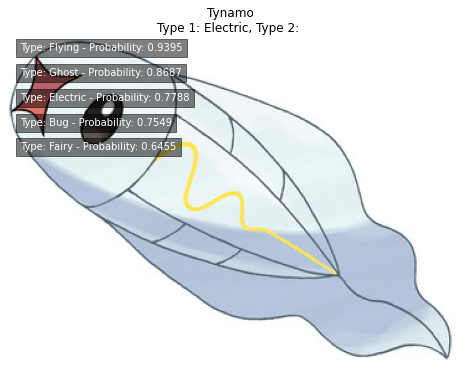

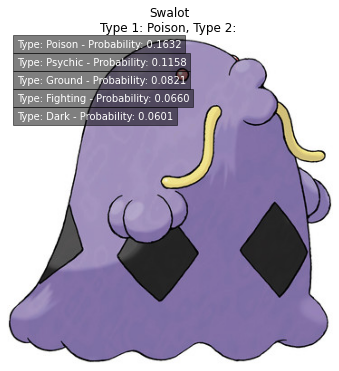

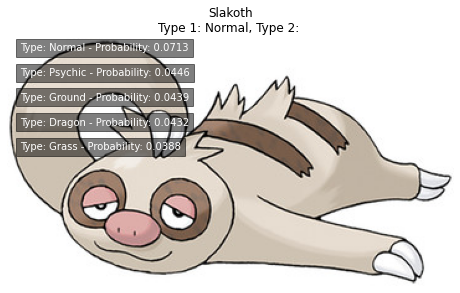

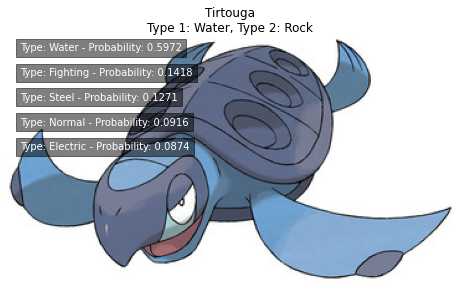

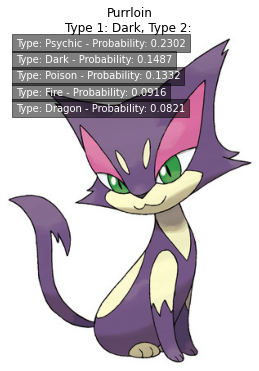

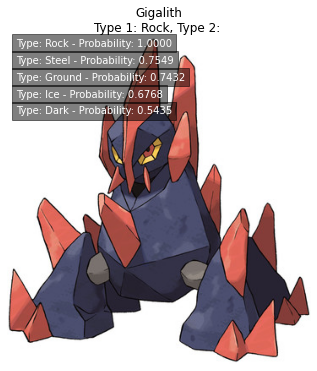

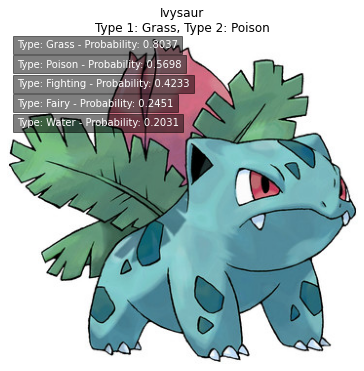

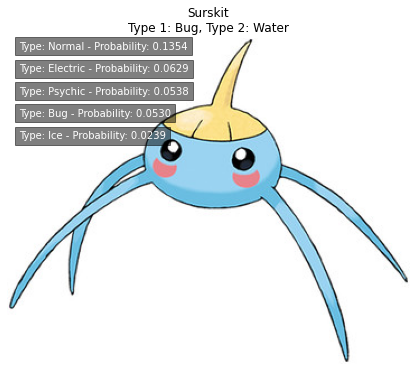

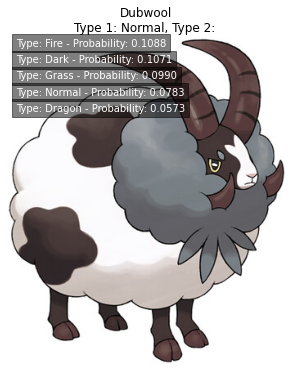

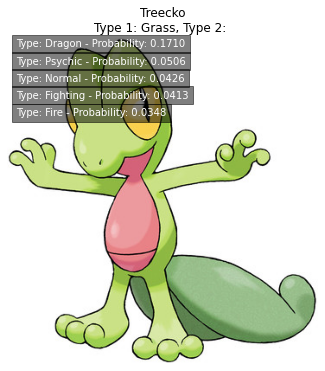

In [ ]:
import pandas as pd
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import normalize
from scipy.special import softmax
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Randomly select 10 Pokemon images
random_indices = np.random.choice(len(pokedex), 10, replace=False)
selected_pokemon = pokedex.iloc[random_indices]

# Get the image paths of selected Pokemon
selected_image_paths = selected_pokemon['image_path'].tolist()

# Perform CLIP inference on selected images
image_embeddings = clip_inference_image(model, preprocess, selected_image_paths, device)

# Perform CLIP inference on type names
type_texts = pokedex['Type1'].unique()
type_dict = type_texts
for i in range(type_texts.shape[0]):
    type_texts[i] = "type: " + type_texts[i]
type_embeddings = clip_inference_text(model, preprocess, type_texts, device)

# Compute similarity between images and type names
similarity_matrix = compute_similarity_image_to_text(image_embeddings, type_embeddings)

# Get the indices of the top 5 relevant types for each image
top_types_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :5]
# print('top', top_types_indices.shape, top_types_indices)
top_types_probabilities = np.take_along_axis(similarity_matrix, top_types_indices, axis=1)
# print('prop', top_types_probabilities.shape, top_types_probabilities)

# Plot each selected Pokemon image along with relevant types and probabilities
for i in range(len(selected_pokemon)):
    pokemon_name = selected_pokemon.iloc[i]['Name']
    first_type = selected_pokemon.iloc[i]['Type1']
    second_type = selected_pokemon.iloc[i]['Type2']
    top_types = pokedex['Type1'].unique()[top_types_indices[i]]
    top_probabilities = top_types_probabilities[i]

    # Plot the image
    img_path = selected_image_paths[i]
    img = Image.open(img_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'{pokemon_name}\nType 1: {first_type}, Type 2: {second_type}')

    # Show the top 5 relevant types and their probabilities
    for j in range(5):
        plt.text(10, 10 + j * 20, f'Type: {top_types[j]} - Probability: {top_probabilities[j]:.4f}', color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.show()

### Question 28

In the first and second question, we investigated how CLIP creates ’clusters’ by mapping images and texts of various Pokemon into a high-dimensional space and explored neighbor- hood of these items in this space. For this question, please use t-SNE to visualize image clusters, specifically for Pokemon types Bug, Fire, and Grass. You can use scatter plot from python package plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’ argument, and label each point with the Pokemon’s name and types using ’hover name’. This will enable you to identify each Pokemon represented in your visualization. After completing the visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.


In [ ]:
import plotly.express as px

# Filter pokedex for Bug, Fire, and Grass types
filtered_pokedex = pokedex[pokedex["Type1"].isin(["Bug", "Fire", "Grass"])]

# Filter image embeddings for Bug, Fire, and Grass types
filtered_image_embeddings = image_embeddings[pokedex["Type1"].isin(["Bug", "Fire", "Grass"])]

# Perform t-SNE projection
tsne_projection = umap_projection(filtered_image_embeddings)

# Create DataFrame for visualization
visualization_df = pd.DataFrame(tsne_projection, columns=['TSNE Component 1', 'TSNE Component 2'])
visualization_df['Name'] = filtered_pokedex['Name']
visualization_df['Type1'] = filtered_pokedex['Type1']
visualization_df['Type2'] = filtered_pokedex['Type2']

# Plot scatter plot with Plotly
fig = px.scatter(visualization_df, x='TSNE Component 1', y='TSNE Component 2', color='Type1',
                 hover_name='Name', hover_data=['Type1', 'Type2'],
                 title='t-SNE Visualization of Pokémon Types (Bug, Fire, Grass)')
fig.show()
